In [1]:
################################################################################
# Generate performance plots from data in given pickle file.

filenames = ['results/QABBA0.1.p', 'results/QABBA0.5.p']
alphas = ['0.1', '0.5']
measures = ['2', 'DTW', '2_diff', 'DTW_diff','time']

################################################################################

import os
import pickle
import warnings
import matplotlib as mpl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
# import sys
# sys.path.append('./../..')
warnings.filterwarnings('ignore')

plt.style.use('default')

In [2]:

def definefigure(nrows=1, ncols=1, fig_ratio=0.71, fig_scale=1): # pragma: no cover
    """
    Parameters
    ----------
    nrows - int
        Number of rows (subplots)

    ncols - int
        Number of columns (subplots)

    fig_ratio - float
        Ratio between height and width

    fig_scale - float
        Scaling which magnifies font size

    Returns
    -------
    fig - matplotlib figure handle

    ax -  tuple of matplotlib axis handles

    Example
    -------
    from util import myfigure
    fig, (ax1, ax2) = myfigure(nrows=2, ncols=1)
    """
    size =12.5

    fig, ax = mpl.pyplot.subplots(nrows=nrows, ncols=ncols, figsize=(8, 7.5), dpi=70*fig_scale, facecolor='w', edgecolor='k')
    mpl.pyplot.subplots_adjust(left=0.05*fig_scale, right=1*fig_scale, bottom=0.085*fig_scale/fig_ratio, top=1-0.05*fig_scale/fig_ratio)

    # Use tex and correct font
    mpl.rcParams['font.family'] = 'DejaVu Sans'
    #mpl.rcParams['font.serif'] = ['computer modern roman']
    #mpl.rcParams['mathtext.fontset'] = 'custom'
    mpl.rcParams['mathtext.rm'] = 'DejaVu Sans'
    mpl.rcParams['mathtext.it'] = 'DejaVu Sans:italic'
    mpl.rcParams['mathtext.bf'] = 'DejaVu Sans:bold'
    mpl.rcParams['font.size'] = size

    # MATLAB default (see MATLAB Axes Properties documentation)
    mpl.rcParams['legend.fontsize'] = size

    # remove margine padding on axis
    mpl.rcParams['axes.xmargin'] = 0
    mpl.rcParams['axes.ymargin'] = 0

    mpl.pyplot.tight_layout(pad=1.3) # padding

    # Save fig with transparent background
    mpl.rcParams['savefig.transparent'] = True

    # Make legend frame border black and face white
    mpl.rcParams['legend.edgecolor'] = 'k'
    mpl.rcParams['legend.facecolor'] = 'w'
    mpl.rcParams['legend.framealpha'] = 1

    # Change colorcycle to MATLABS
    c = mpl.cycler(color = ['lightseagreen', 'blueviolet', 'olivedrab', 'darkorange', 'tomato', 'cornflowerblue'])

    if isinstance(ax, np.ndarray):
        ax = ax.ravel()
        for axi in ax:
            axi.set_prop_cycle(c) # color cycle
            axi.xaxis.label.set_size(1.8*size) # xaxis font size
            axi.yaxis.label.set_size(1.8*size) # yaxis font size
            axi.tick_params(axis='both', which='both', labelsize=size, direction='in') # fix ticks
    else:
        ax.set_prop_cycle(c) # color cycle
        ax.tick_params(axis='both', which='both', labelsize=size, direction='in') # fix ticks
        ax.xaxis.label.set_size(1.8*size) # xaxis font size
        ax.yaxis.label.set_size(1.8*size) # yaxis font size

    return fig, ax


def PerformanceProfile(A, th_max, 
            file_name, alg_legend, n_intervals=100,
            markevery=1):

    m, n = A.shape
    minA = np.min(A, 1)

    fig, ax = definefigure(nrows=1, ncols=1, fig_ratio=0.71, fig_scale=2.6)

    # Use definition at some points theta
    n_intervals = 100;
    theta = np.linspace(1, th_max, num = n_intervals);
    T = np.zeros([n_intervals,1]);

    linestyle = ['-', ':', '--', '-.']
    marker = ['o', '^', 'p', '*', 'x', 'v', '<', 'h', ]
    for j in np.arange(0,n):
        for k in np.arange(0,n_intervals):
            T[k] = np.sum(A[:,j] <= theta[k]*minA)/m;

        plt.plot(theta, T, linestyle=linestyle[j%4], marker=marker[j%8], markersize=15, linewidth=5, markevery=markevery)

    plt.xlim([1, th_max])
    plt.ylim([0, 1.01])
    plt.xlabel(r'$\theta$', fontsize=40)
    plt.ylabel(r'$\rho$', fontsize=40)
    plt.tick_params(axis='both', labelsize=28)
    plt.rcParams['axes.facecolor'] = 'white'
    plt.grid(True)
    if not alg_legend == None:
        plt.legend(alg_legend, bbox_to_anchor=(0.5, -0.33), ncols=3, loc='center', fontsize=20)
    plt.tight_layout()
    
    plt.savefig(file_name, facecolor='w', edgecolor='w', bbox_inches='tight')
    plt.show()
    

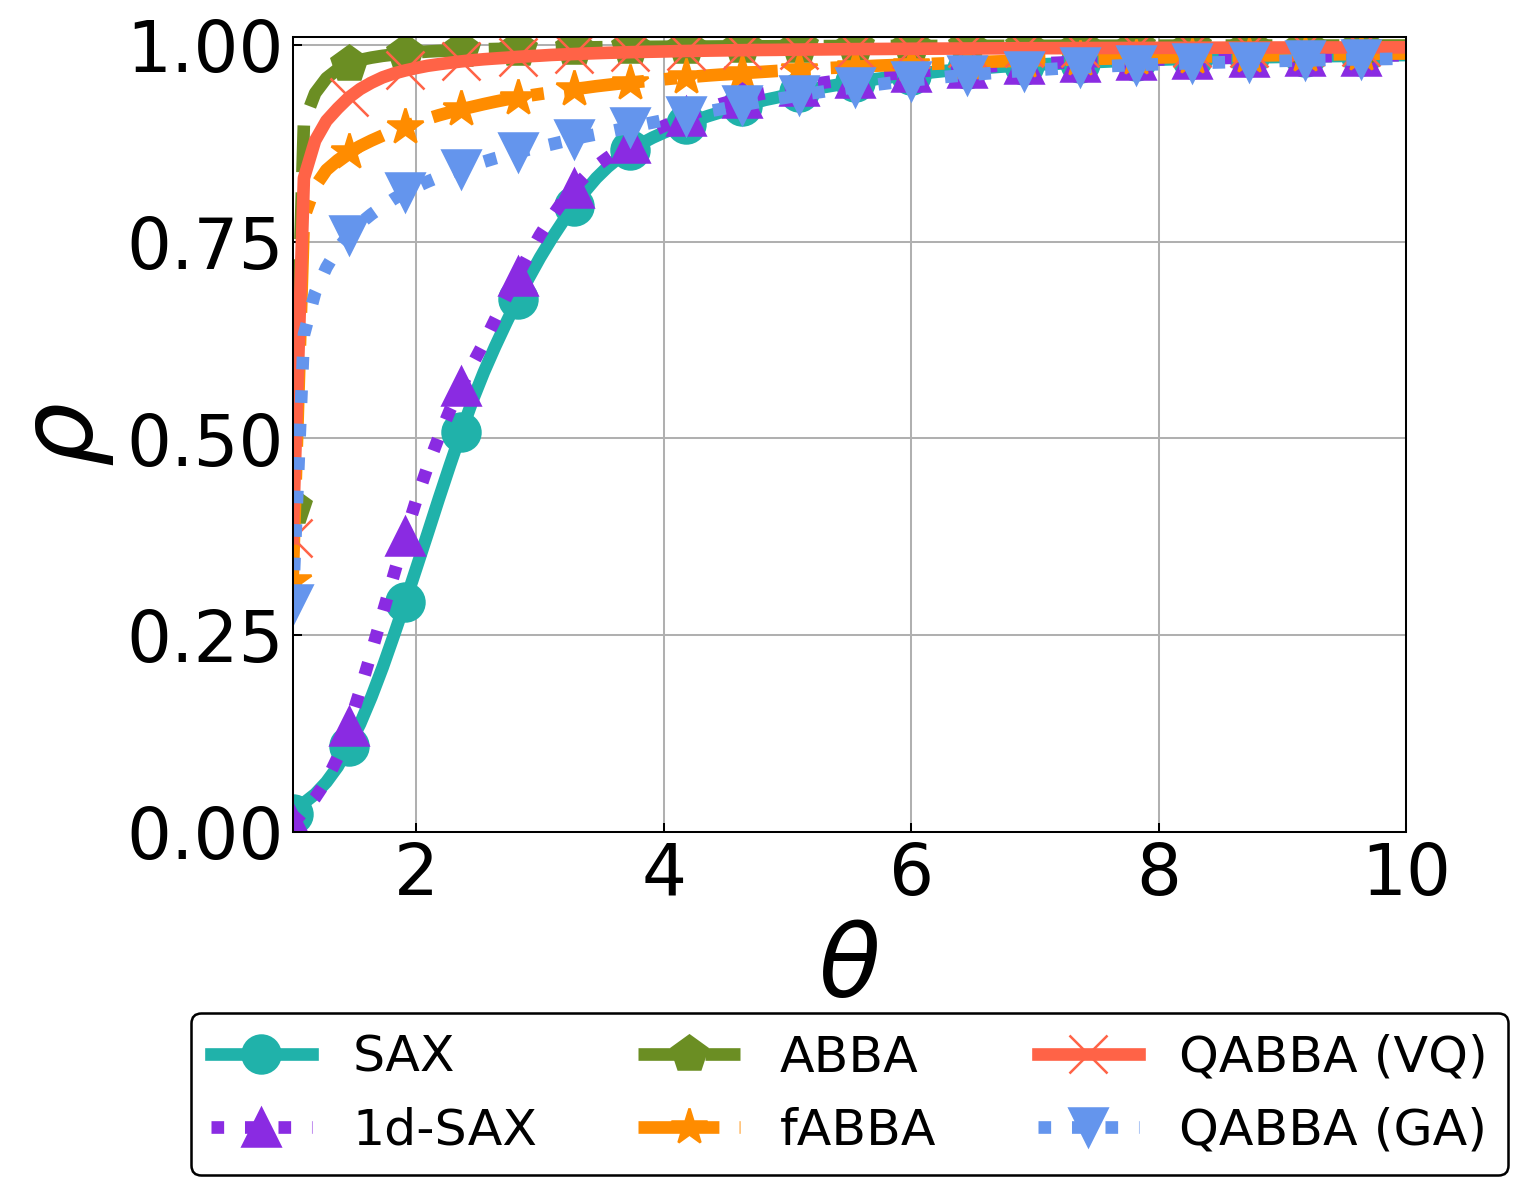

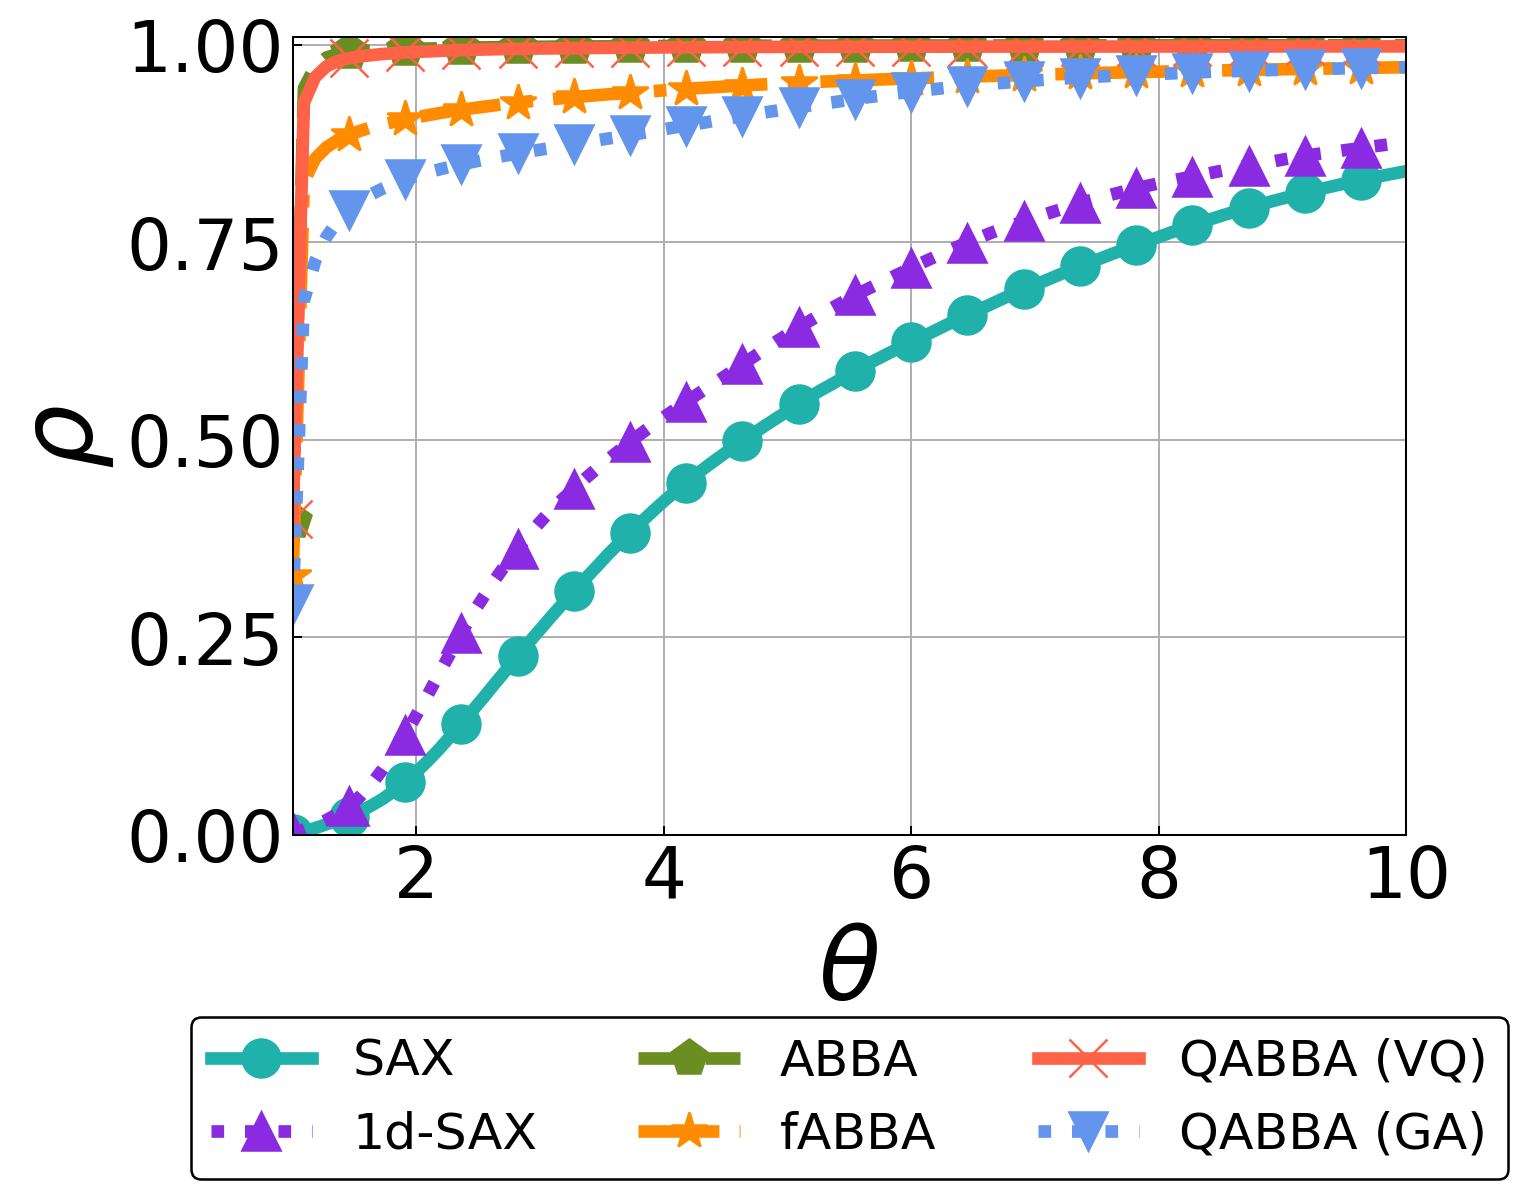

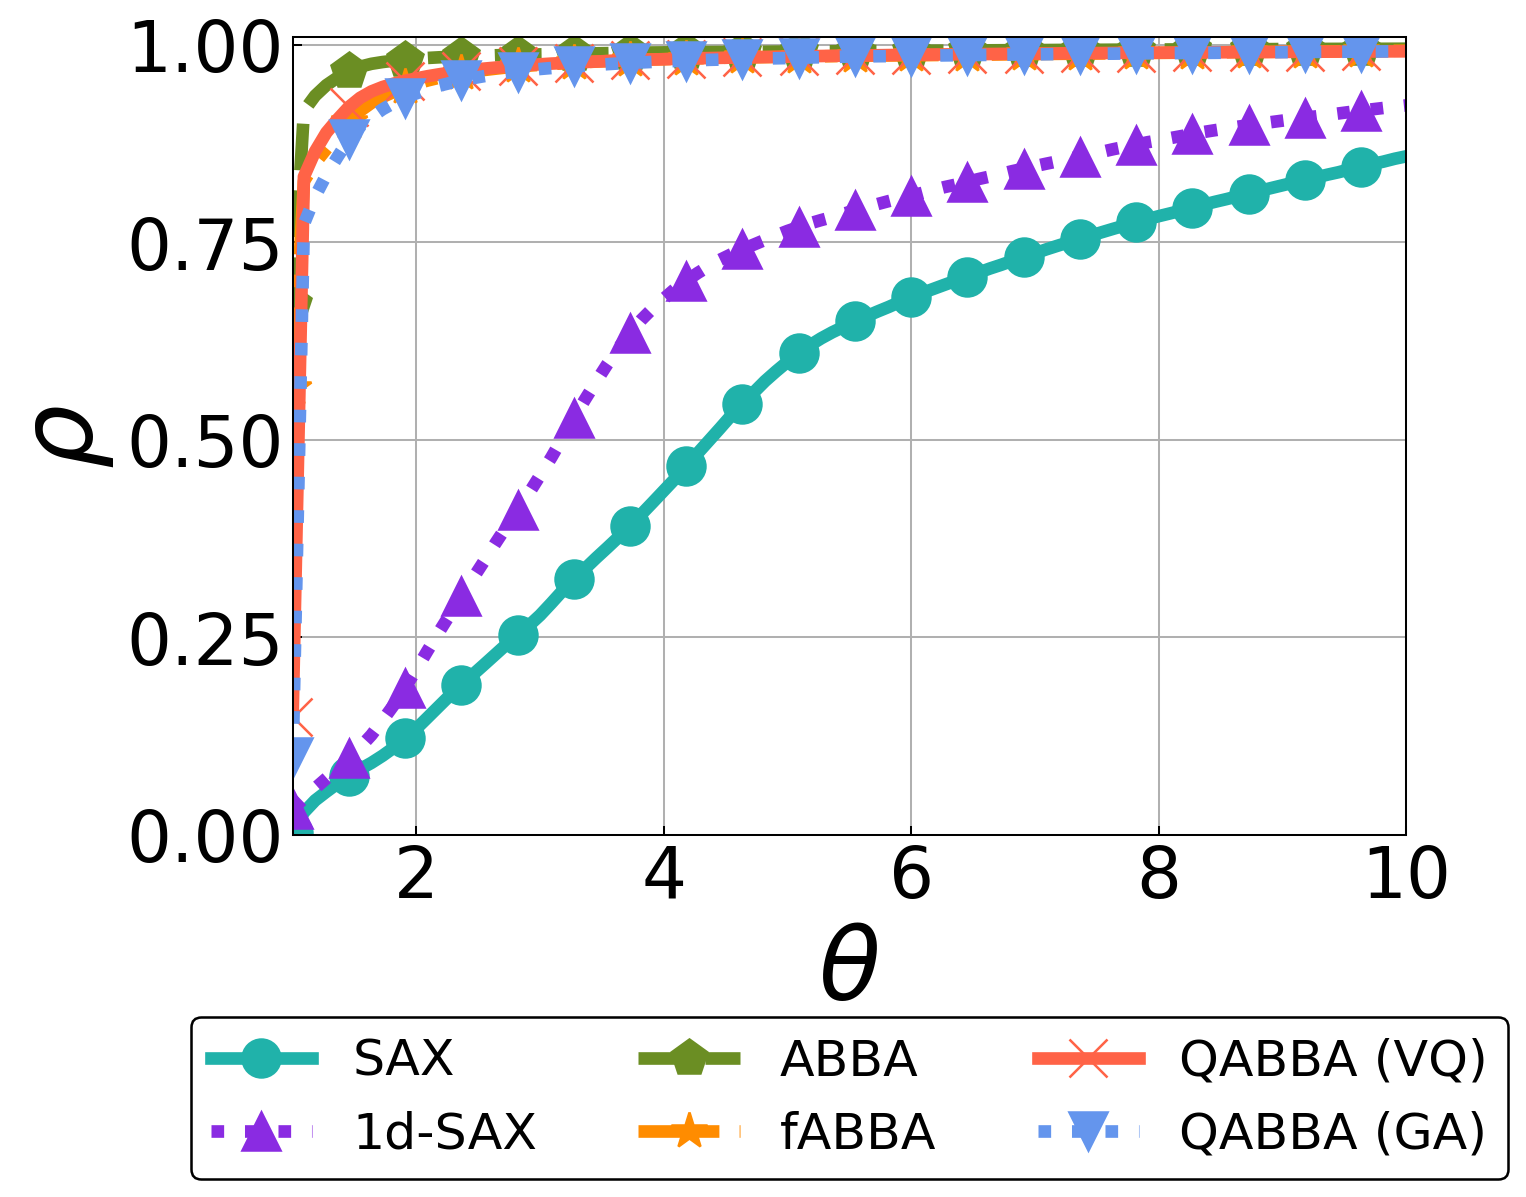

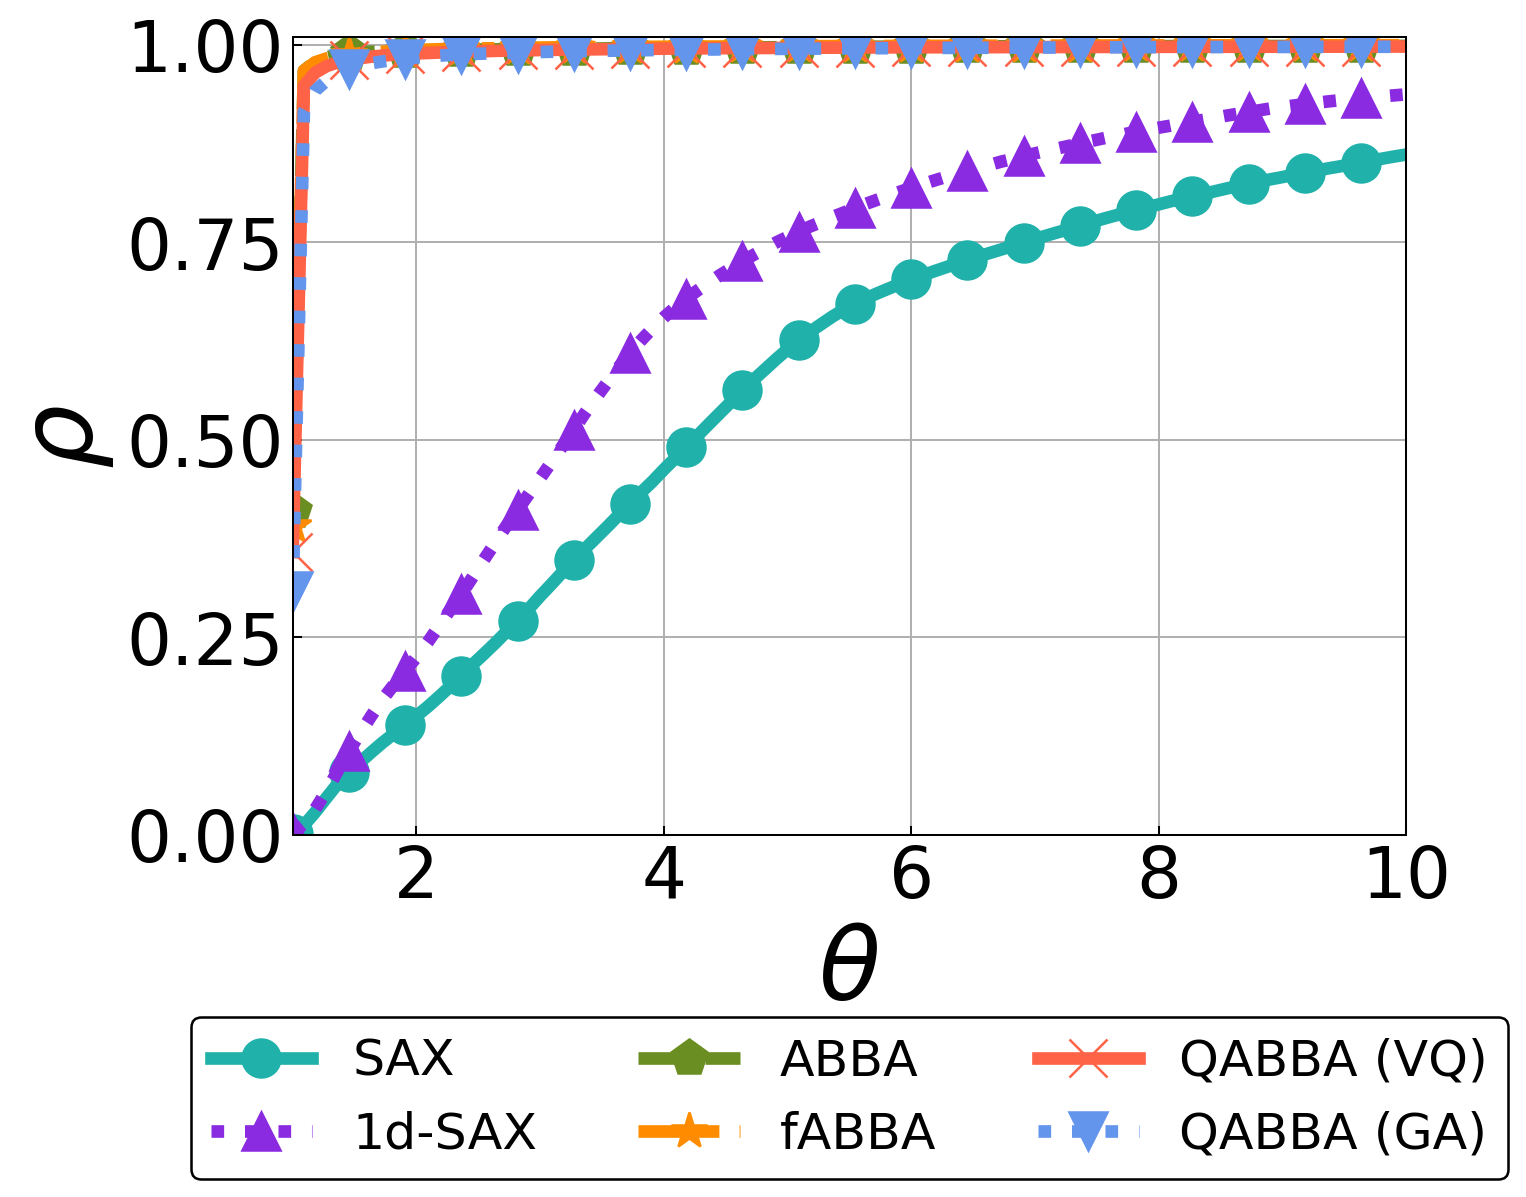

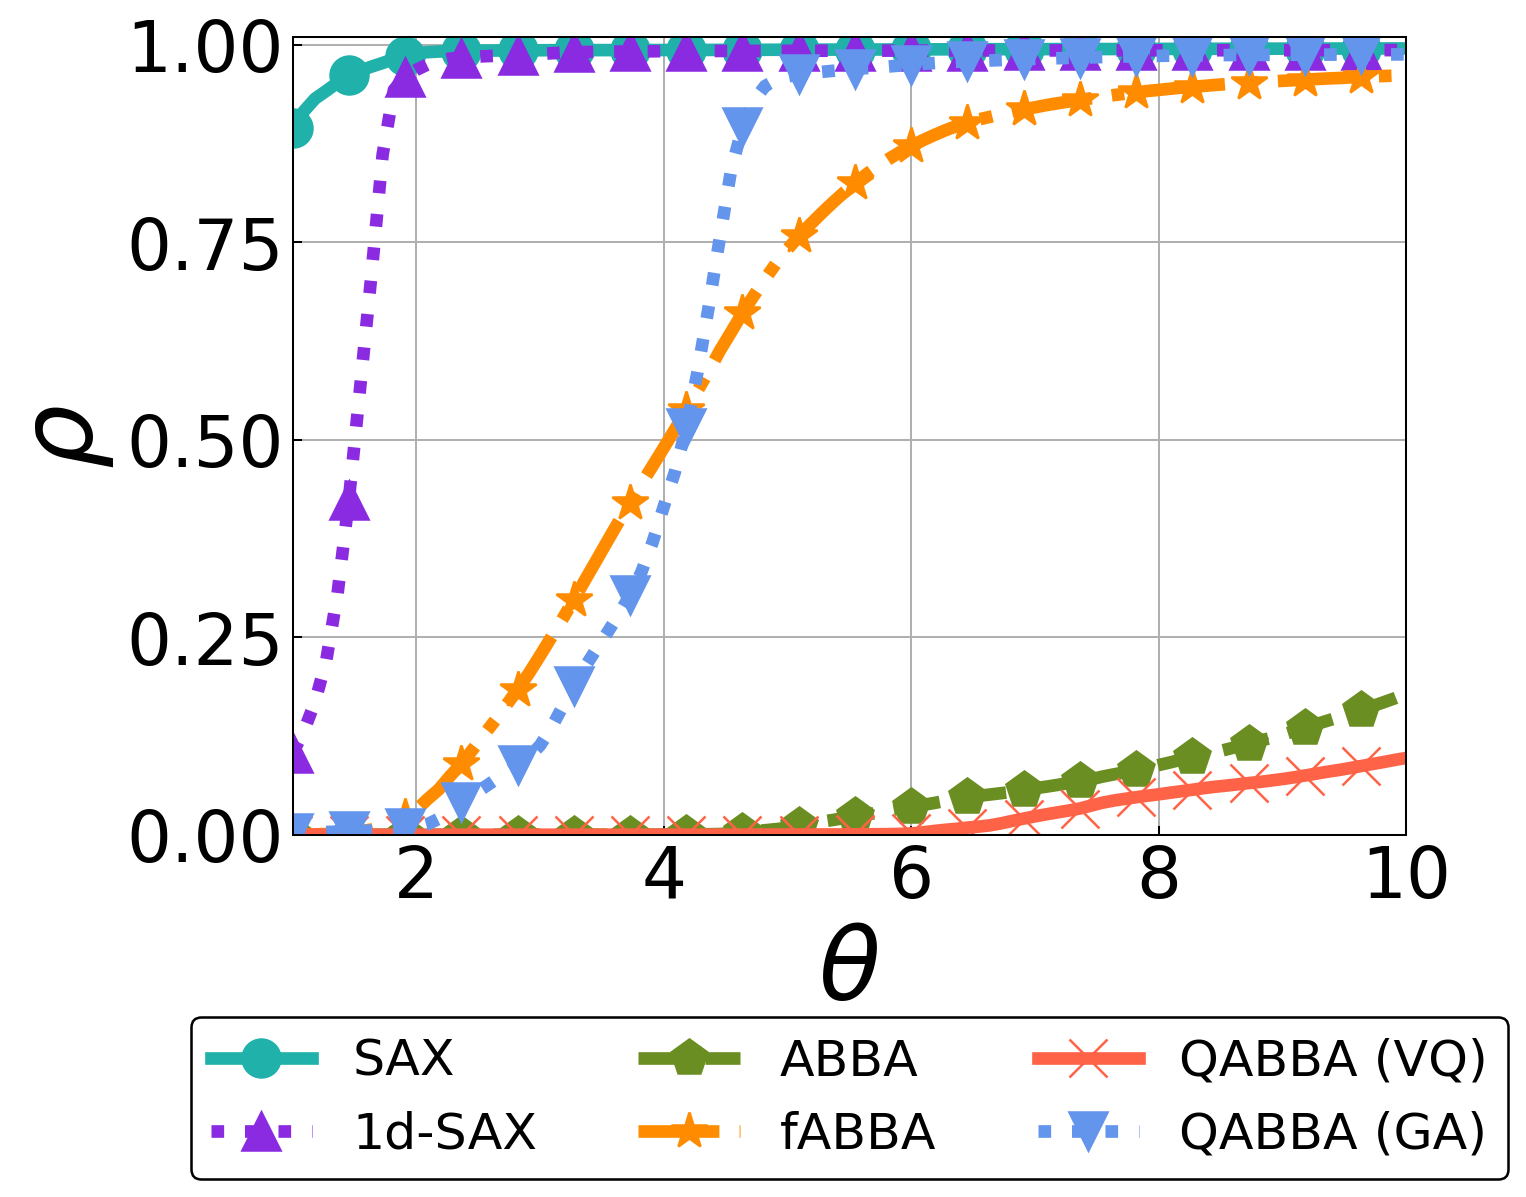

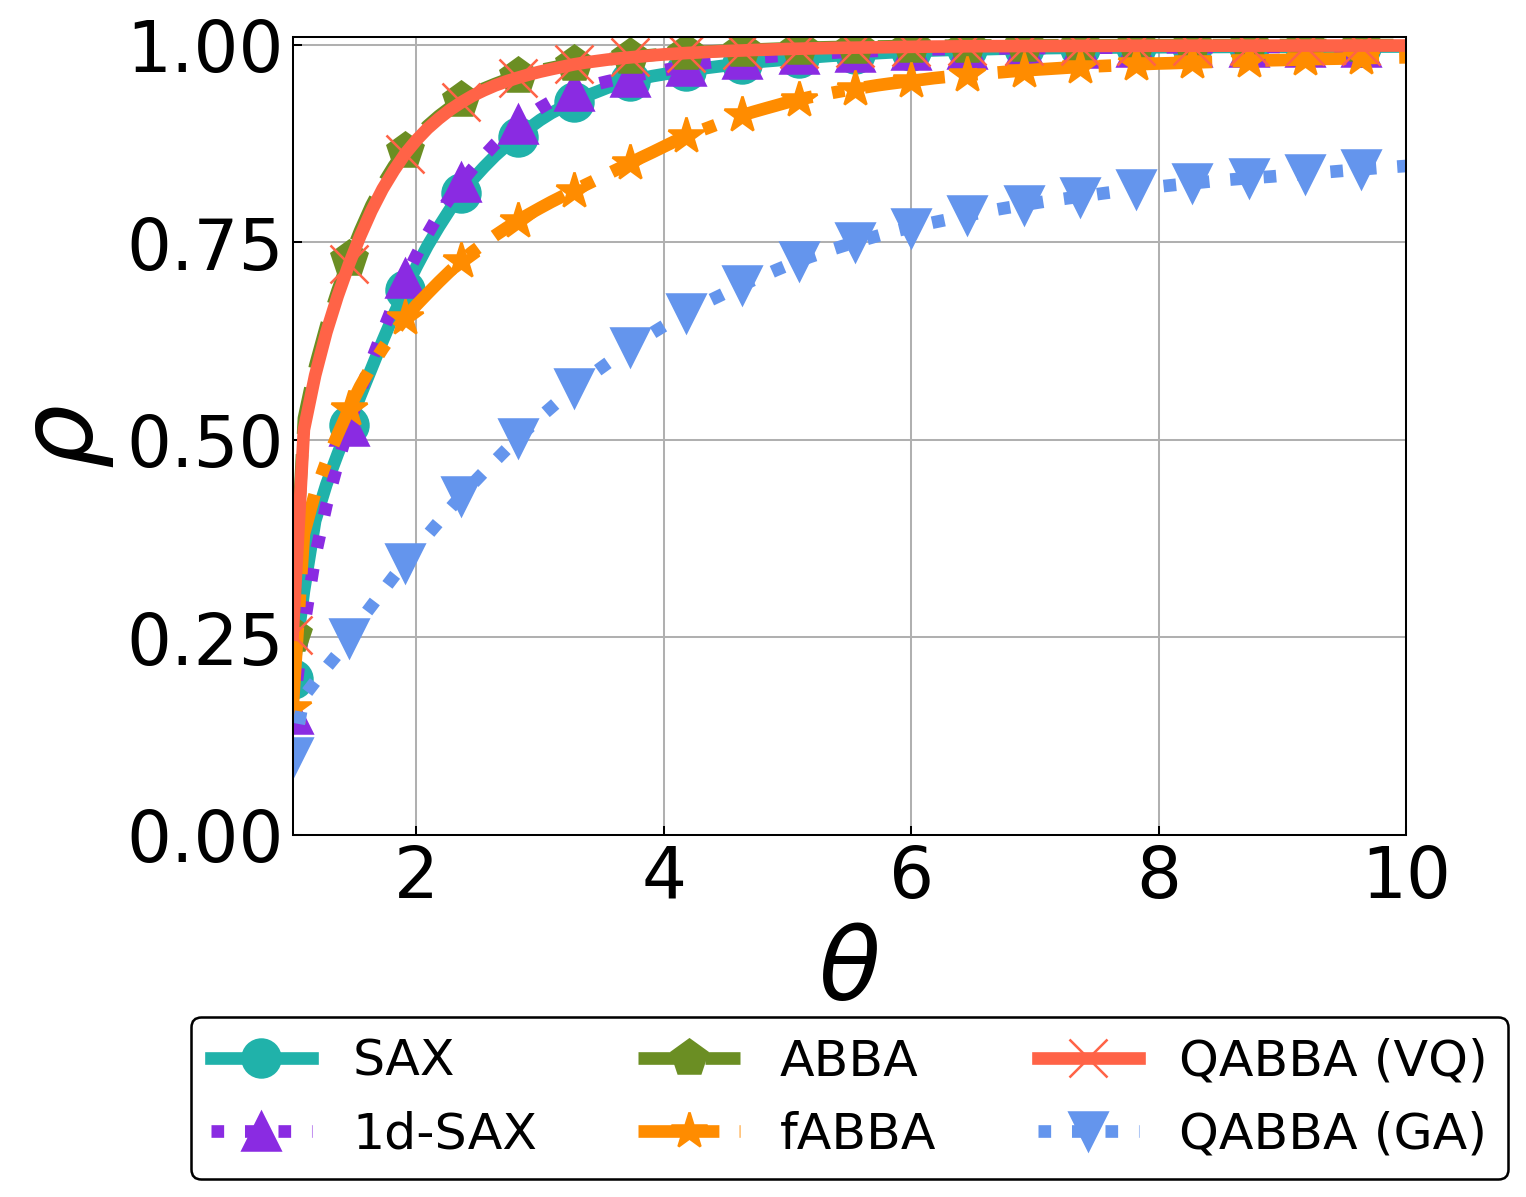

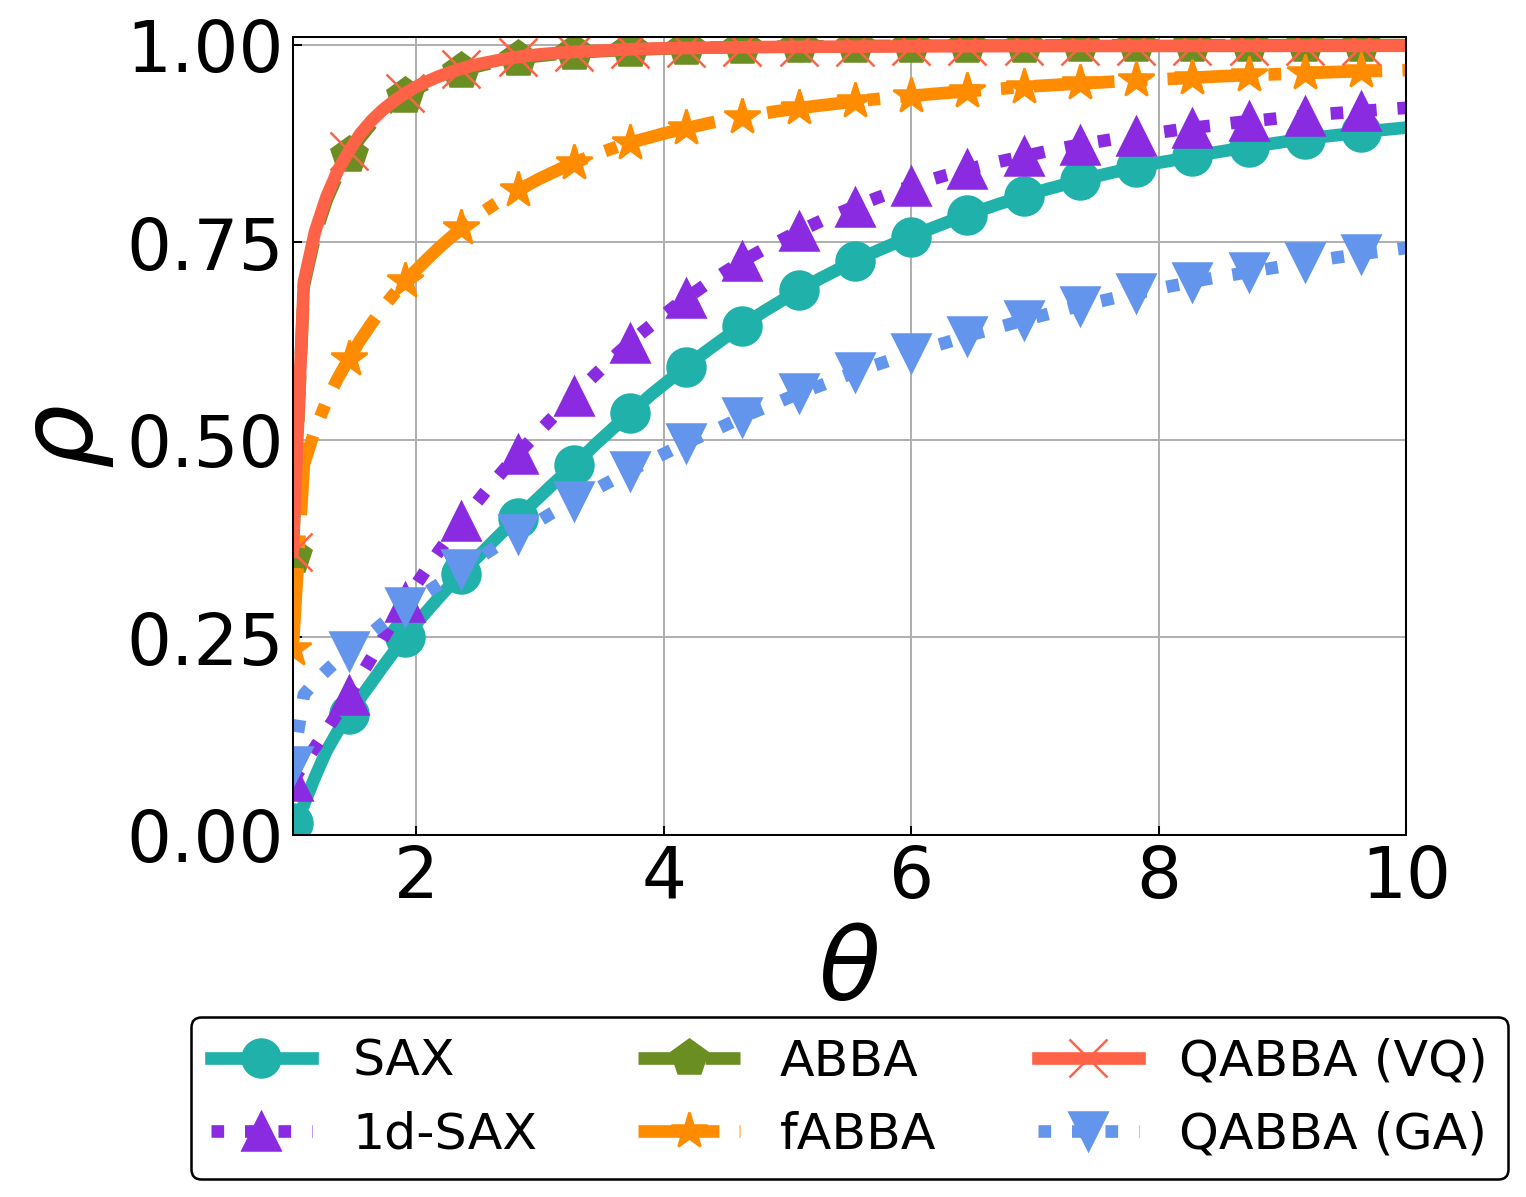

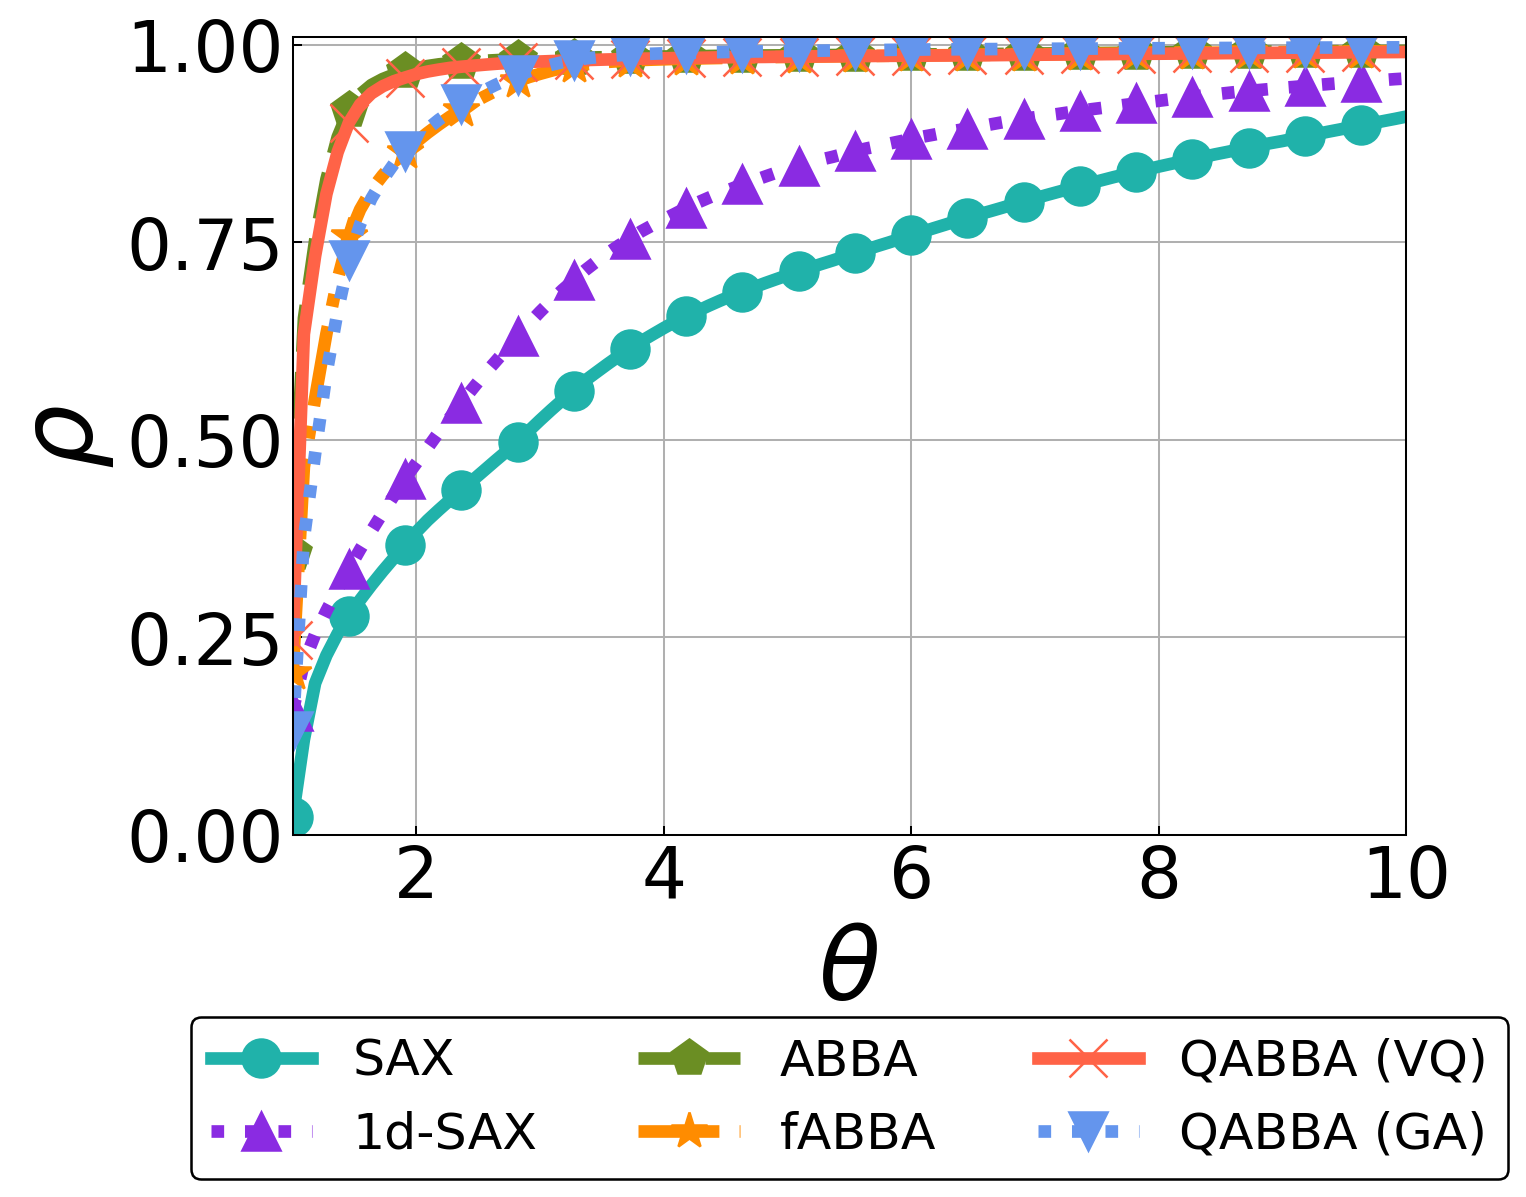

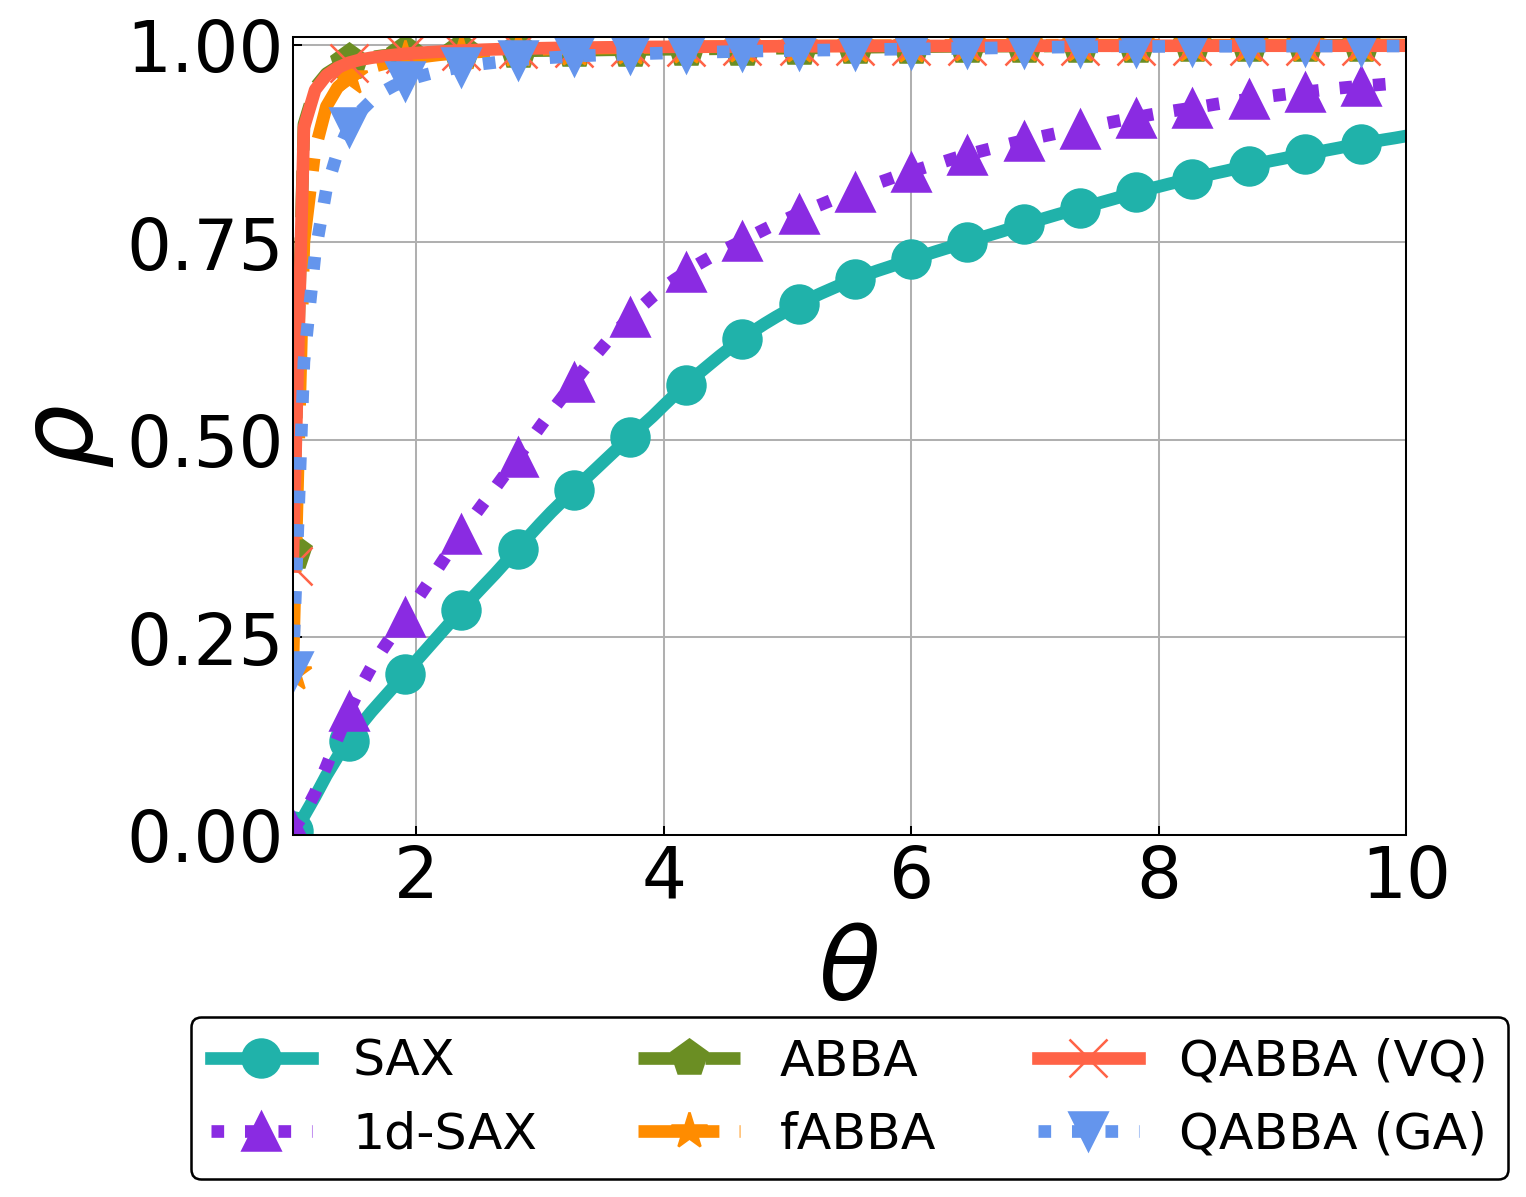

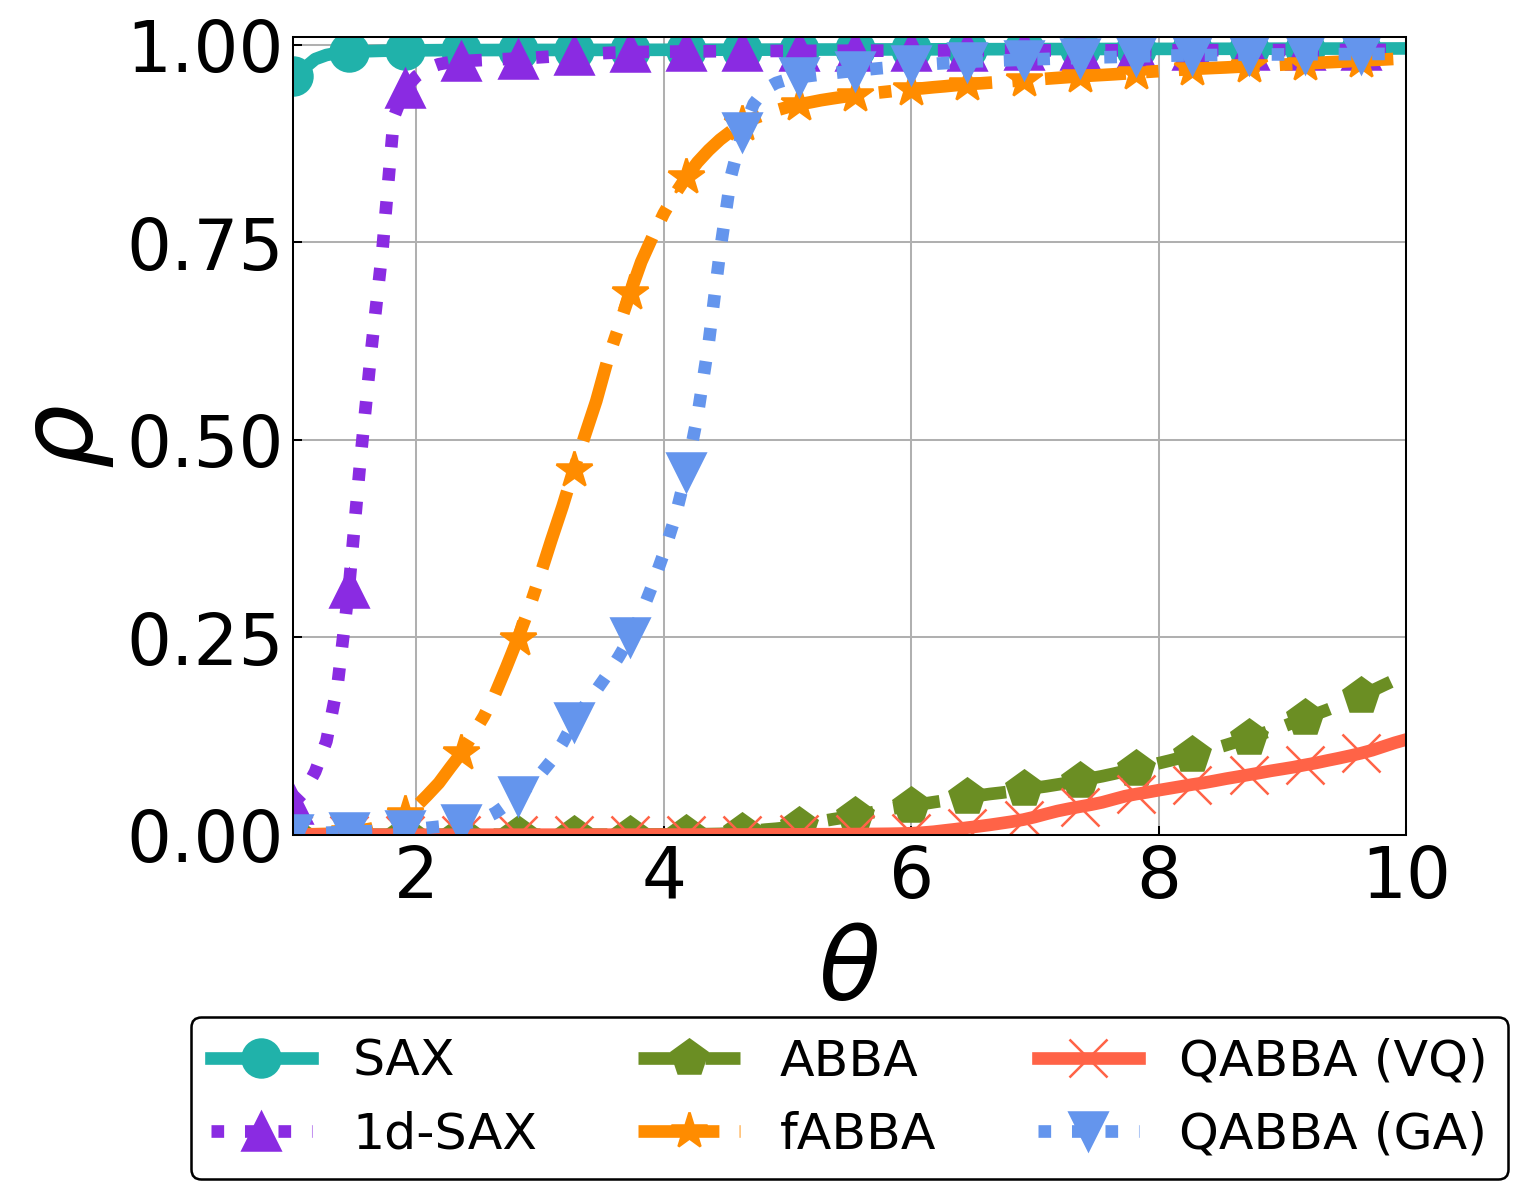

In [3]:
for i in range(len(filenames)):
    filename = filenames[i]
    D = pickle.load(open(filename, 'rb'))

    # Save figures in folder
    for m in measures:
        plt.close()
        plt.rcParams['axes.facecolor'] = 'white'
        P = (np.vstack([D['SAX_'+m], D['oneD_SAX_'+m], D['ABBA_'+m], D['fABBA_'+m], D['QABBA1_'+m], D['QABBA2_'+m]])).T
        P = P[~np.isnan(P).any(axis=1)] # remove NaN rows
        PerformanceProfile(P, 10, 
                           file_name='results/pp'+ '/' + alphas[i] + '/' + m + '.pdf', 
                           alg_legend=['SAX','1d-SAX','ABBA','fABBA','QABBA (VQ)', 'QABBA (GA)'], 
                           markevery=5)
        
    # If txt file exists, delete it
    if os.path.exists('results/pp'+ '/' + str(alphas[i]) + '/'  + 'info.txt'):
        os.remove('results/pp'+ '/' + str(alphas[i]) + '/'  + 'info.txt')
    
    # Create text file with key information and save in same folder
    with open('results/pp'+ '/' + str(alphas[i]) + '/'  + 'info.txt', 'a') as f:
        compression = np.array(D['compression'])
        ind = ~np.isnan(compression)
        failures = np.sum(np.isnan(compression))
        form_tol = ['%.2f' % elem for elem in D['tol']]
        f.write('tol: '+str(form_tol)+'\n'+'\n')
        f.write('Number of time series: '+str(len(D['compression']))+'\n')
        f.write('Success: '+ str(len(D['compression'])-failures)+'\n')
        f.write('Failures: '+str(failures)+'\n'+'\n')
        f.write('Average compression percentage: '+str(np.mean(compression[ind]))+'\n'+'\n')
        d = {}
        d['nan'] = 0
        for i in D['tol_used']:
            if math.isnan(i):
                d['nan'] += 1
            elif i in d:
                d[i] += 1
            else:
                d[i] = 1
        f.write('tol used: \n')
        f.write('nan: '+str(d['nan'])+'\n')
        del d['nan'] # sort not support < between float and string
        for i in sorted(d):
            f.write(str(i)[0:4]+': '+str(d[i])+'\n')

        f.write('\n')
        f.write('No error: '+ str(D['error'].count(0))+'\n')
        f.write('Time series too short: '+ str(D['error'].count(1))+'\n')
        f.write('Not enough pieces: '+ str(D['error'].count(2))+'\n')
        f.write('Data too noisy: '+ str(D['error'].count(3))+'\n')
        f.write('Unknown error: '+ str(D['error'].count(4) + D['error'].count(4) )+'\n')
        f.write('ValueError error: '+ str(D['error'].count(5) + D['error'].count(5) )+'\n')
        f.write('ABBAError error: '+ str(D['error'].count(6) + D['error'].count(6) )+'\n')
        f.write('fABBAError error: '+ str(D['error'].count(7) + D['error'].count(7) )+'\n')
        f.write('QABBAError error: '+ str(D['error'].count(8) + D['error'].count(8) )+'\n')


